In [1]:
import neutromeratio
import torch
from neutromeratio.parameter_gradients import setup_mbar, get_experimental_values
from neutromeratio.ani import AlchemicalANI1ccx, AlchemicalANI1x, AlchemicalANI2x
from tqdm import tqdm
import pickle
from neutromeratio.utils import generate_tautomer_class_stereobond_aware
from neutromeratio.constants import kT, _get_names, kT_to_kJ_mol
from simtk import unit
import numpy as np
import scipy.stats as scs


[__init__.py:17 - <module>()] Enabling RDKit 2020.03.6 jupyter extensions


[utils.py:141 - _init_num_threads()] NumExpr defaulting to 8 threads.


In [4]:
all_names = neutromeratio.constants._get_names()
base = '/home/mwieder/Work/Projects/neutromeratio/data/retraining/'
#base = '/home/mwieder/Work/Projects/neutromeratio/data/CHON_vacuum_ANI1ccx_200_training_validation_test_a7srv3/'
results_test_set = pickle.load(open(base + '/results_on_test_set.pickle', 'rb+'))
results_before_retraining = pickle.load(open(base + '/results_before_training.pickle', 'rb+'))


In [5]:
len([e for e in results_before_retraining if results_before_retraining[e][1] == 'v'])

57

In [6]:
training = [10.846373558044434, 6.689236164093018, 4.531013488769531, 4.018781661987305, 3.663743495941162, 3.3699965476989746, 3.1097073554992676, 2.8756415843963623, 2.6627585887908936, 2.4654390811920166, 2.2812774181365967, 2.111534595489502, 1.9592252969741821, 1.8276458978652954, 1.716910719871521]
validation = [9.236249923706055, 4.52219820022583, 4.319699764251709, 4.297789096832275, 4.364434242248535, 4.5019989013671875, 4.663865089416504, 4.827881336212158, 4.99169921875, 5.152098178863525, 5.306168556213379, 5.453770160675049, 5.599338531494141, 5.743778228759766, 5.882842540740967 ]

In [8]:
original_ = []
reweighted_ = []
exp_ = []
names_ = []
for n in results_test_set:
    original, reweighted, exp = results_test_set[n]
    names_.append(n)
    original_.append((original * kT).value_in_unit(unit.kilocalorie_per_mole))
    reweighted_.append((reweighted * kT).value_in_unit(unit.kilocalorie_per_mole))
    exp_.append((exp * kT).value_in_unit(unit.kilocalorie_per_mole))

/home/mwieder/anaconda3/envs/ani36/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mwieder/anaconda3/envs/ani36/lib/python3.7/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/mwieder/anaconda3/envs/ani36/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarni

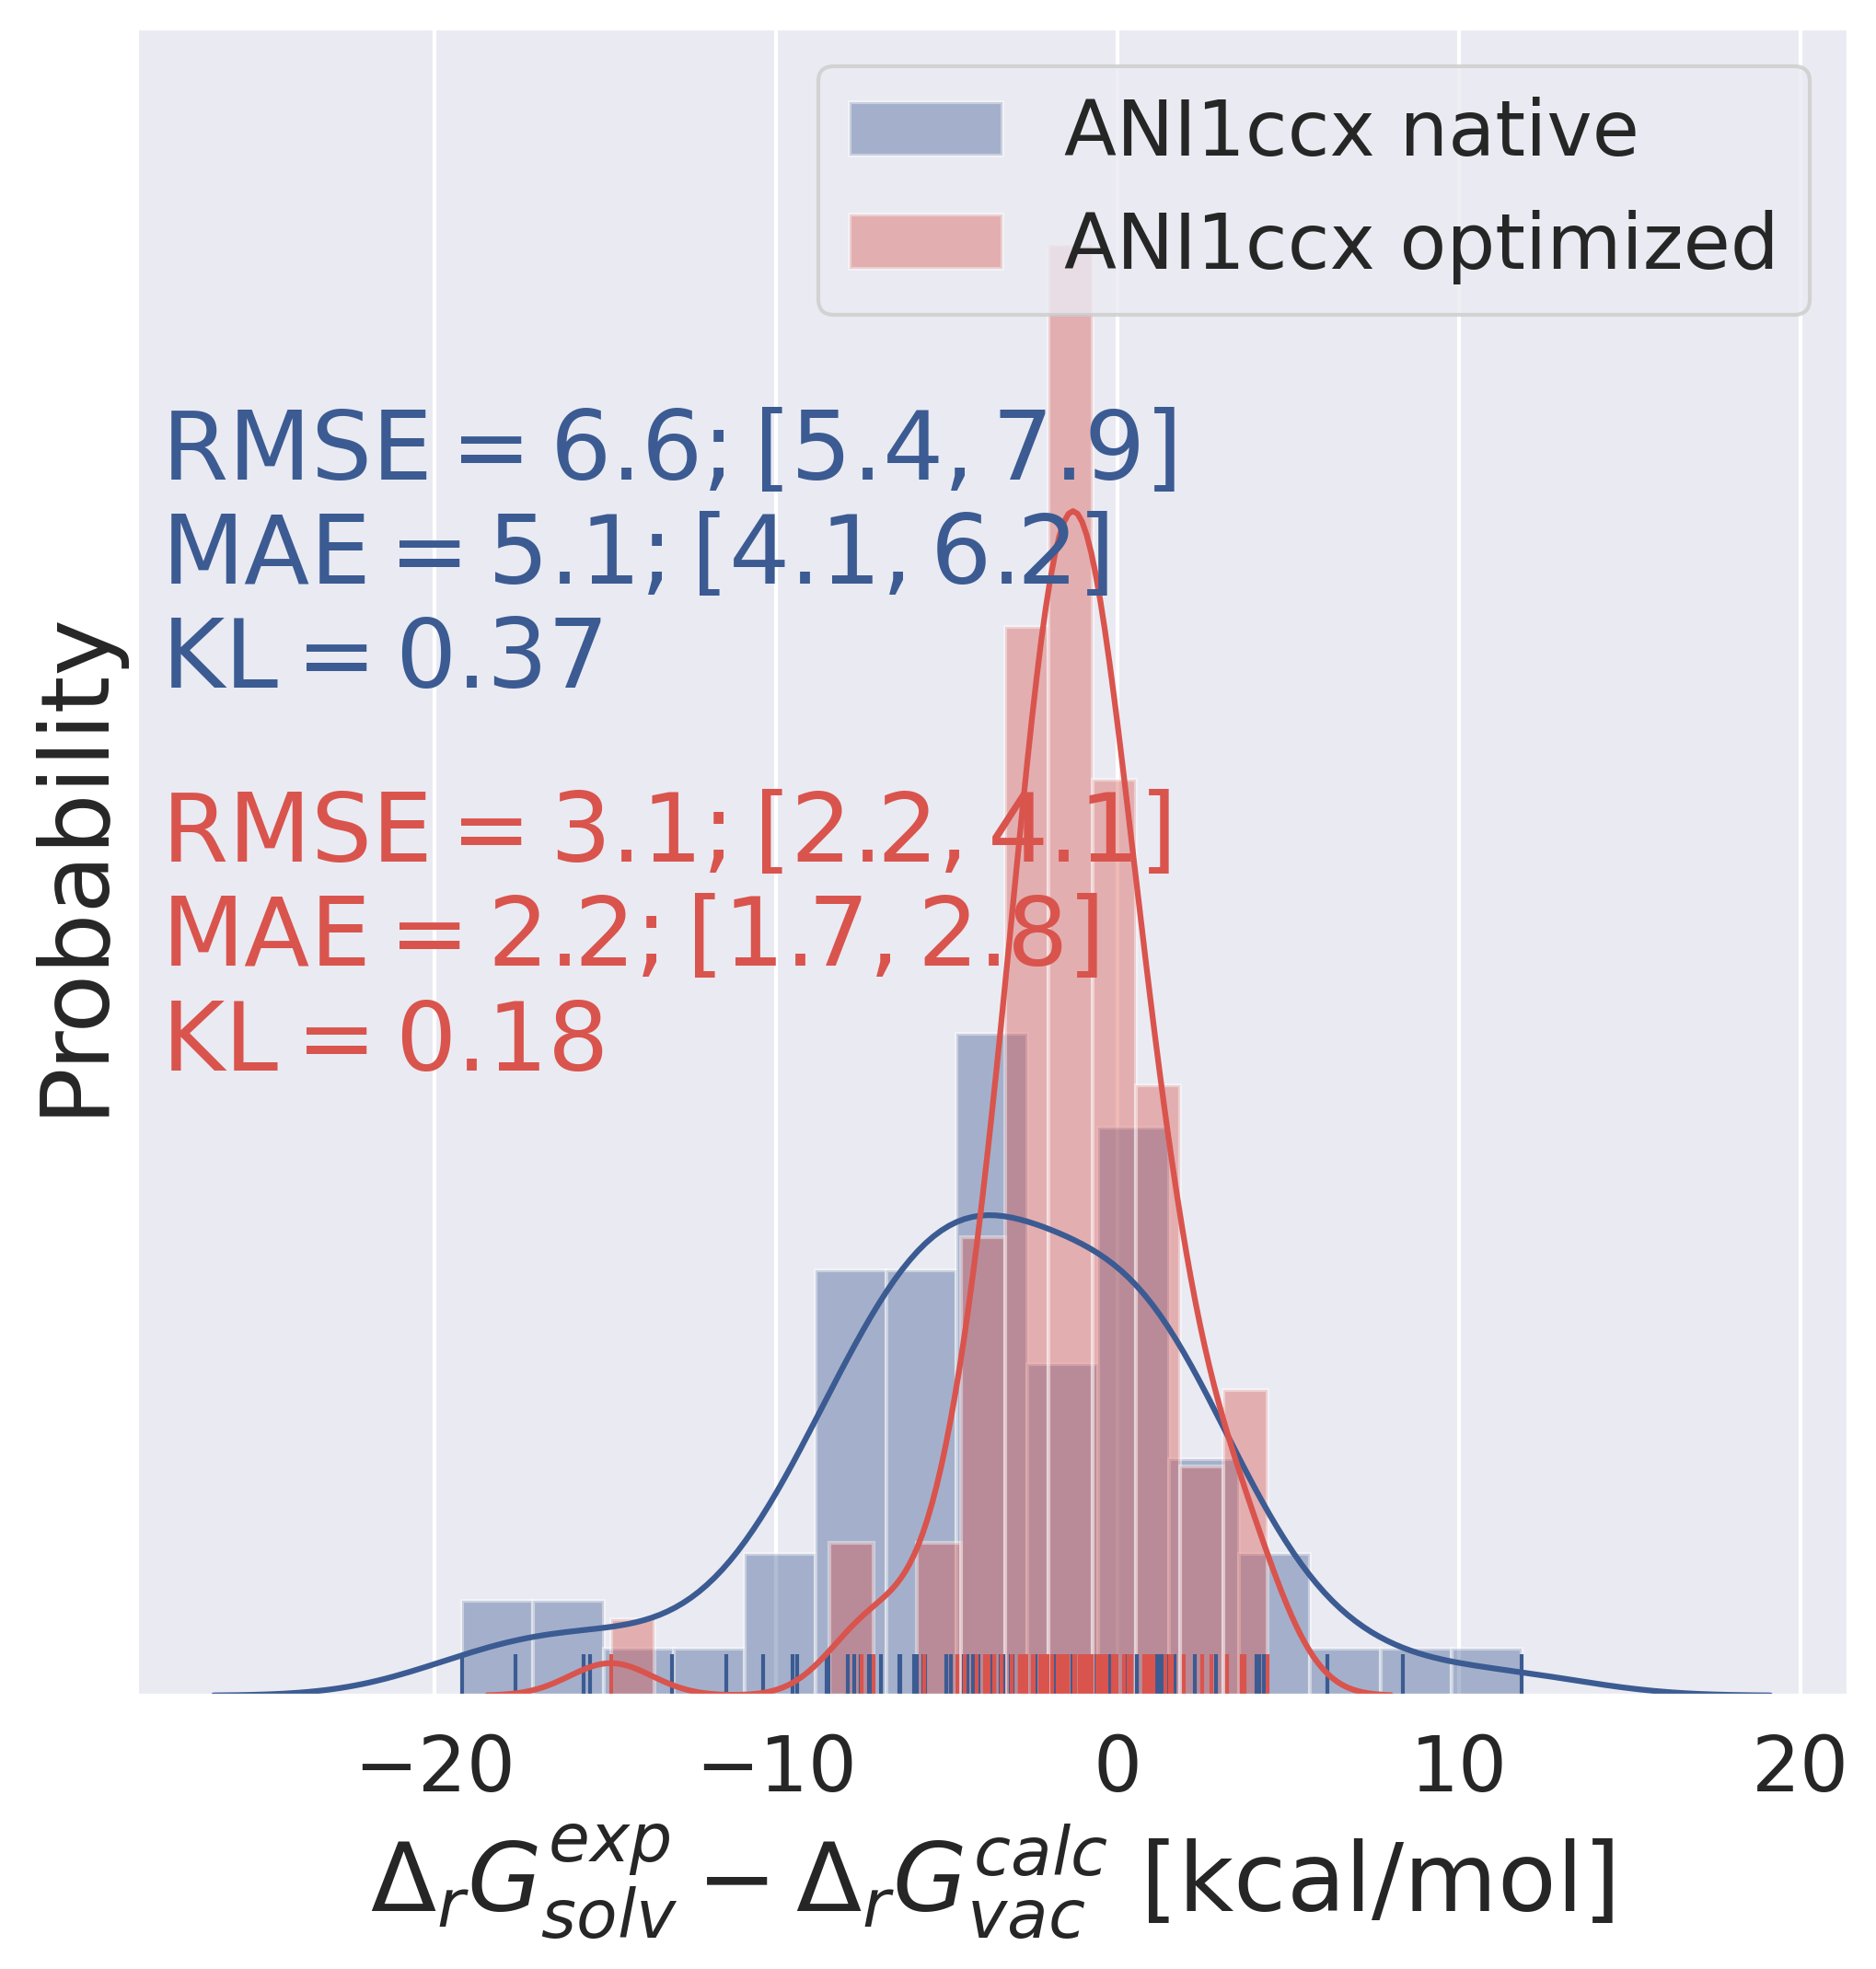

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from scipy.stats import entropy
from neutromeratio.analysis import compute_kl_divergence, bootstrap_rmse_r
sns.set(color_codes=True)
plt.figure(figsize=[8, 8], dpi=300)
fontsize = 25
delta_exp_original = np.array(exp_) - np.array(original_)
kl = compute_kl_divergence(np.array(exp_), np.array(original_))
rmse, mae, rho = (bootstrap_rmse_r(np.array(exp_), np.array(original_), 1000))
plt.text(-28.0, 0.175, f"RMSE$ = {rmse}$", fontsize=fontsize, color=sns.xkcd_rgb["denim blue"])
plt.text(-28.0, 0.16, f"MAE$ = {mae}$", fontsize=fontsize, color=sns.xkcd_rgb["denim blue"])
plt.text(-28.0, 0.145, f"KL$ = {kl:.2f}$", fontsize=fontsize, color=sns.xkcd_rgb["denim blue"])

sns.distplot(delta_exp_original, kde=True, rug=True, bins=15, label="ANI1ccx native", color=sns.xkcd_rgb["denim blue"])
delta_exp_reweighted = np.array(exp_) - np.array(reweighted_)
rmse, mae, rho = (bootstrap_rmse_r(np.array(exp_), np.array(reweighted_), 1000))
kl = compute_kl_divergence(np.array(exp_), np.array(reweighted_))
plt.text(-28.0, 0.12, f"RMSE$ = {rmse}$", fontsize=fontsize, color=sns.xkcd_rgb["pale red"])
plt.text(-28.0, 0.105, f"MAE$ = {mae}$", fontsize=fontsize, color=sns.xkcd_rgb["pale red"])
plt.text(-28.0, 0.09, f"KL$ = {kl:.2f}$", fontsize=fontsize, color=sns.xkcd_rgb["pale red"])
sns.distplot(delta_exp_reweighted, kde=True, rug=True, bins=15, label="ANI1ccx optimized", color=sns.xkcd_rgb["pale red"])
plt.legend(fontsize=fontsize-5)
plt.ylabel('Probability', fontsize=fontsize)
plt.xlabel('$\Delta_{r} G_{solv}^{exp} -  \Delta_{r} G_{vac}^{calc}$ [kcal/mol]', fontsize=fontsize)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)

plt.yticks([])



plt.show()

In [11]:
f = pickle.load(open(f'{base}/results_epoch_1.pickle', 'rb+'))

exp_corresponding_to_validation_set = [(float(get_experimental_values([name])[0].item()) ) for name in sorted(f.keys()) if f[name][1] == 'v']
validation_set_before_retrainting = [(float(results_before_retraining[name][0])) for name in sorted(f.keys()) if f[name][1] == 'v']
bootstrap_rmse_r(np.array(exp_corresponding_to_validation_set), np.array(validation_set_before_retrainting), 1000)

(9.2; [7.3, 11.4], 7.0; [5.5, 8.5], 0.7; [0.5, 0.8])

In [12]:
from neutromeratio.analysis import bootstrap_rmse_r
validation_results_bootstrapped = list()
f = pickle.load(open(f'{base}/results_epoch_1.pickle', 'rb+'))

exp_corresponding_to_validation_set = [(float(get_experimental_values([name])[0].item()) * kT).value_in_unit(unit.kilocalorie_per_mole) for name in sorted(f.keys()) if f[name][1] == 'v']
validation_set_before_retrainting = [(float(results_before_retraining[name][0]) * kT).value_in_unit(unit.kilocalorie_per_mole) for name in sorted(f.keys()) if f[name][1] == 'v']


for i in range(0, 15):
    if i == 0:
        validation_results_bootstrapped.append(bootstrap_rmse_r(np.array(exp_corresponding_to_validation_set), np.array(validation_set_before_retrainting), nsamples=1000))
    else:
        f = pickle.load(open(f'{base}/results_epoch_{i}.pickle', 'rb+'))
        validation_results = [(float(f[name][0]) * kT).value_in_unit(unit.kilocalorie_per_mole) for name in sorted(f.keys()) if f[name][1] == 'v']
        validation_results_bootstrapped.append(bootstrap_rmse_r(np.array(exp_corresponding_to_validation_set), np.array(validation_results), nsamples=1000))

In [14]:
training = [(e * kT).value_in_unit(unit.kilocalorie_per_mole) for e in training]
validation = [(e * kT).value_in_unit(unit.kilocalorie_per_mole) for e in validation]

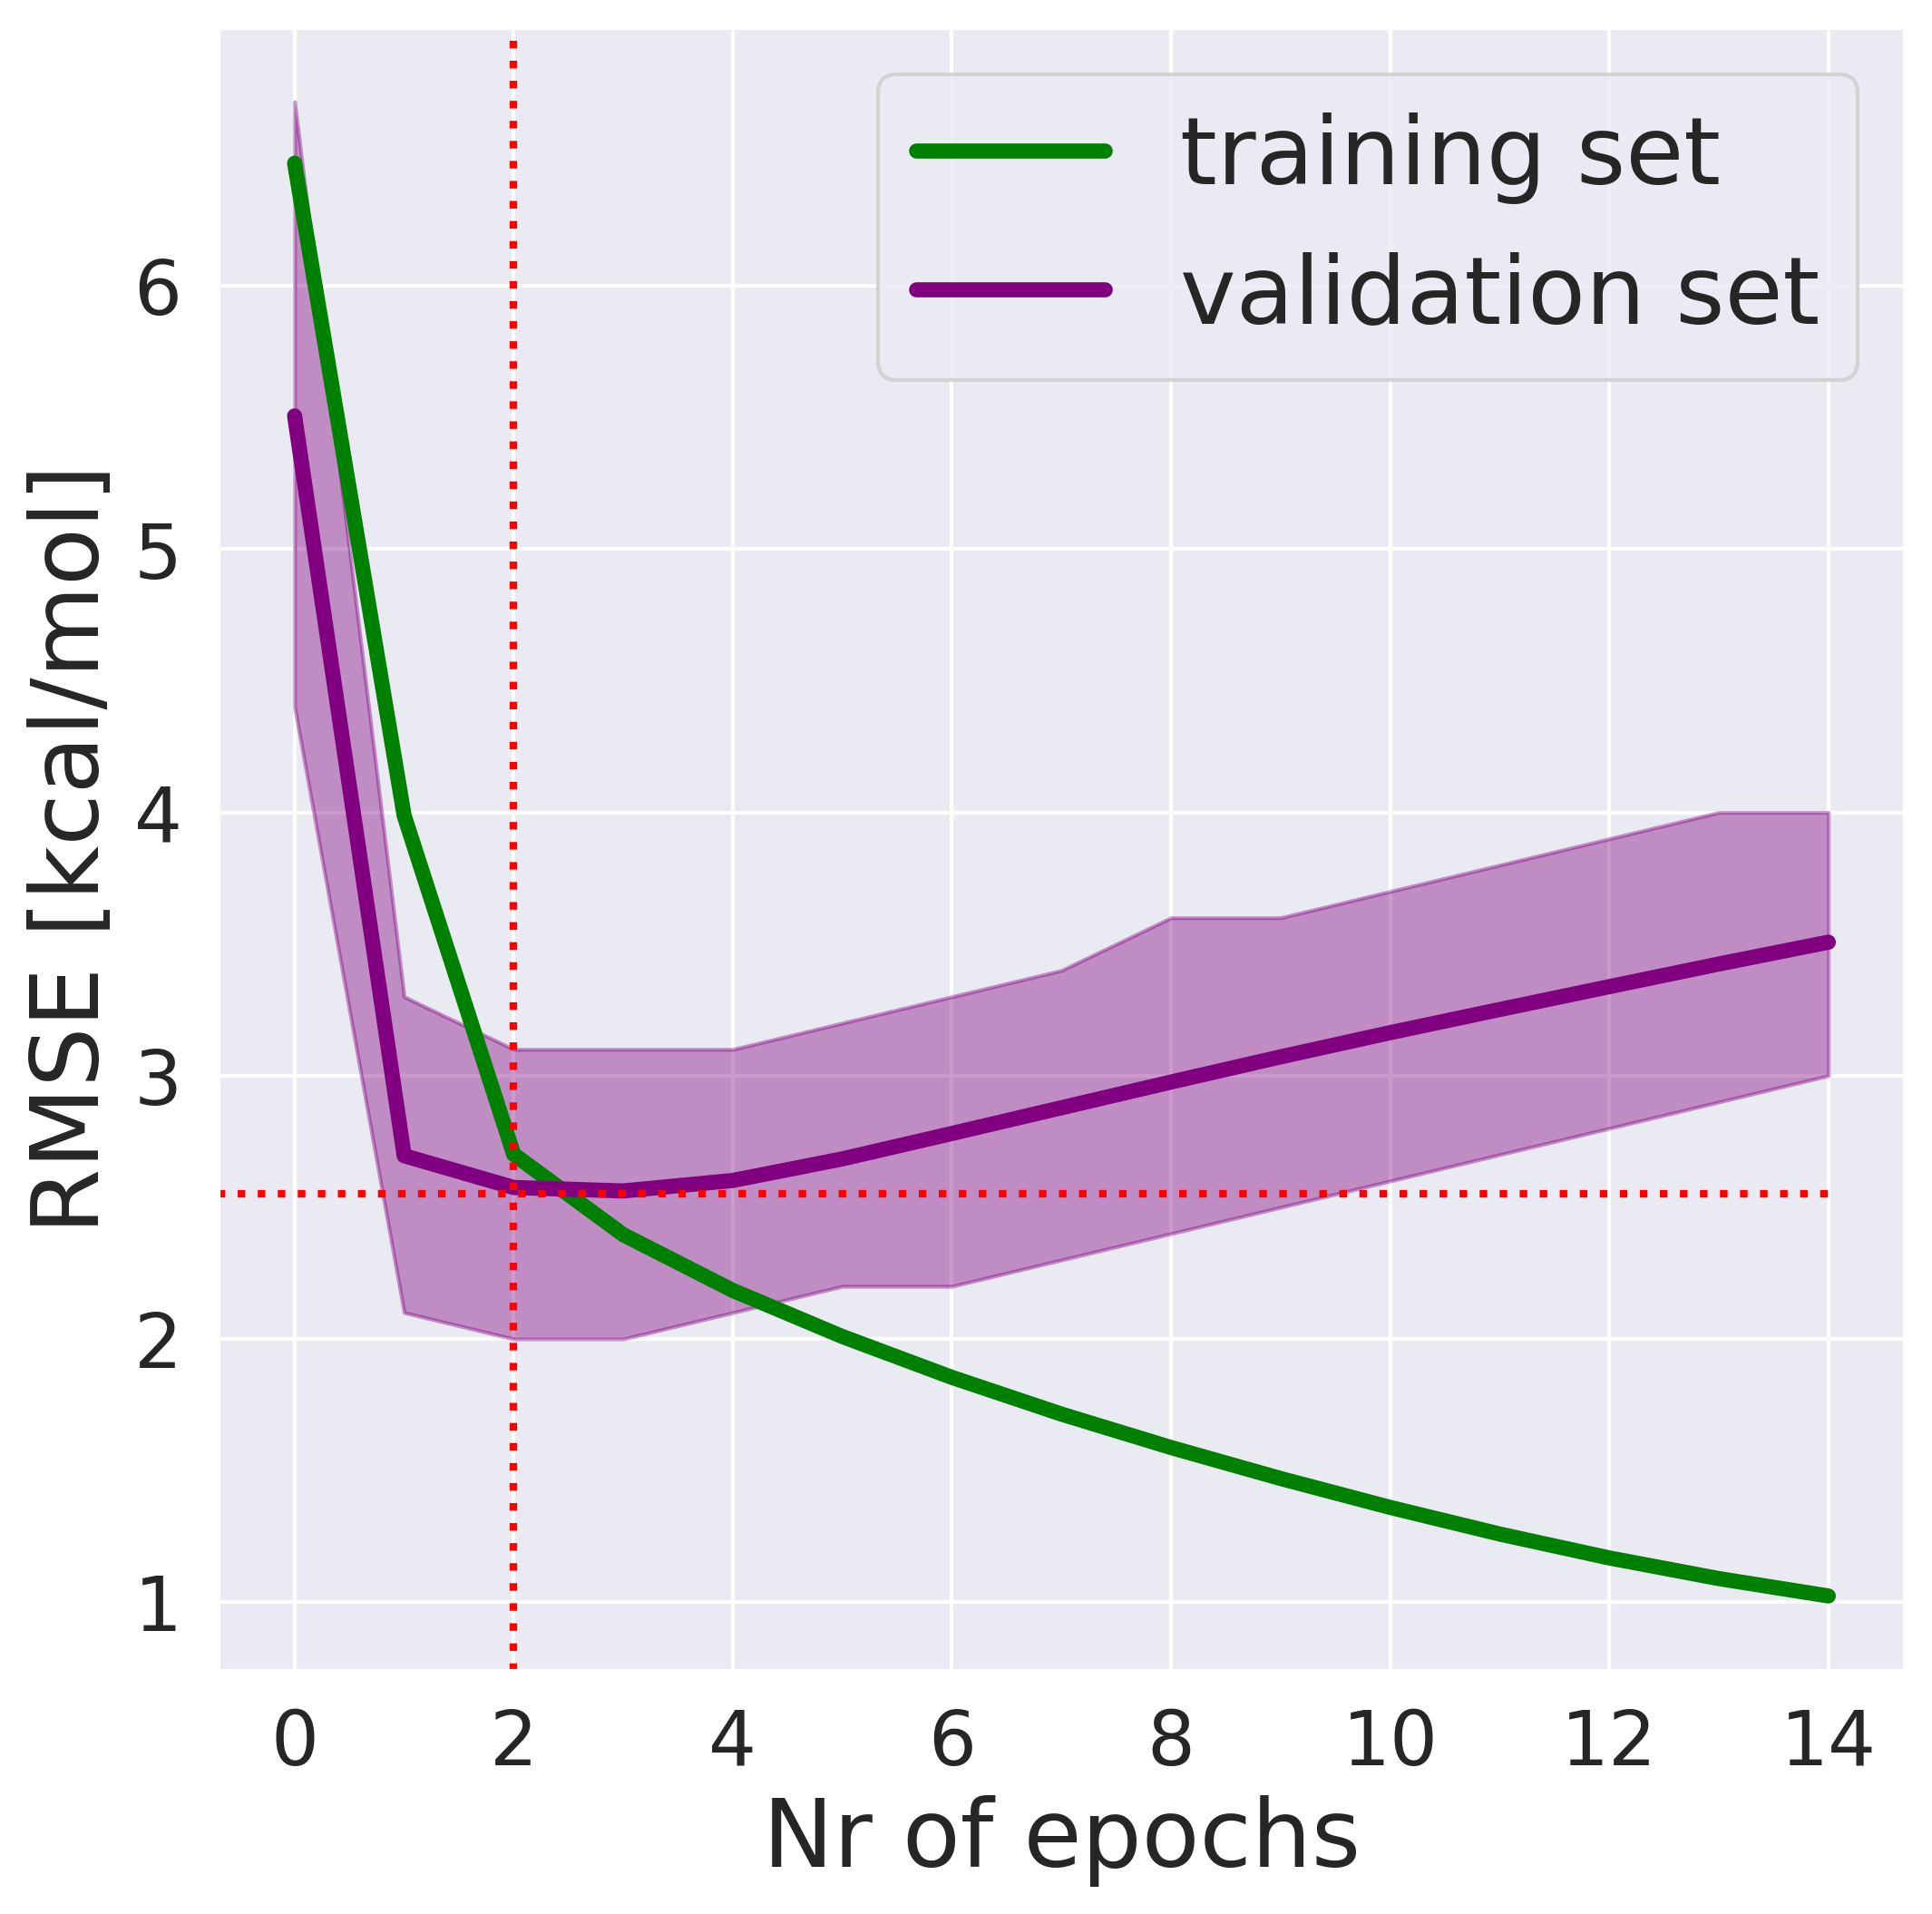

In [15]:
import numpy as np
import seaborn as sns
sns.set(color_codes=True)

plt.figure(figsize=[8, 8], dpi=300)
fontsize = 25
plt.style.use('seaborn-deep')
plt.plot(training, linewidth=4, label='training set', color='green')
plt.plot(validation, linewidth=4, label='validation set', color='purple')
lower_bound = [v[0].bootstrap_percentiles(95)[1] for v in validation_results_bootstrapped]
upper_bound = [v[0].bootstrap_percentiles(95)[2] for v in validation_results_bootstrapped]
plt.fill_between(np.linspace(0,14,15), lower_bound, upper_bound, alpha=0.4, color='purple')
plt.xlabel('Nr of epochs', fontsize=fontsize)
plt.axvline(2,0,14, color='red', linewidth=2, linestyle=':')
plt.axhline(2.55,0,0.96, color='red', linewidth=2, linestyle=':')
plt.ylabel('RMSE [kcal/mol]', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.show()